In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from deeplearning_model import EarlyStopping, ModelSaver,evaluate_regression_model,train_regression_model
from deeplearning_model import plot_learning_curves,plot_learning_loss_curves
from torch import optim
import math

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


# 自定义全连接层layer

In [3]:


# 自定义线性层类，自定义权重，偏置属性，使用初始化分布方法和前向计算的foword方法

class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        """
        自定义线性层的初始化
        
        参数:
            in_features: 输入特征数量
            out_features: 输出特征数量
            bias: 是否使用偏置项
        """
        super(MyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # 定义权重参数，使用正态分布初始化
        # 使用Parameter将tensor注册为可学习参数
        #torch.randn(out_features, in_features) *  0.01生成正态分布的随机数
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        # 是否使用偏置
        self.use_bias = bias
        
        # 如果使用偏置，则torch.zeros：初始化偏置参数全0，否则注册一个不存在的偏置参数
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features)) #torch.Tensor(out_features) 生成全0的tensor
        else:
            # 注册一个不存在的偏置参数
            self.register_parameter('bias', None)
        
        # 初始化参数
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        初始化参数
        torch.randn使用kaiming_uniform_初始化方法
        1 / math.sqrt(fan_in) 初始化偏置参数是kaiming_uniform_初始化方法
        1 / math.sqrt(fan_in+fan_out)是Xavier 均匀分布初始化方法，也称为 Glorot 初始化。
        """
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.use_bias:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) 
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        """
        前向传播计算
        
        参数:
            x: 输入张量，形状为 [batch_size, in_features]
            
        返回:
            输出张量，形状为 [batch_size, out_features]
        """
        # 实现线性变换：y = xW^T + b,等价与F.linear(x, self.weight, self.bias)
        output = torch.matmul(x, self.weight.t())
        if self.bias is not None:
            output += self.bias
        return output
    
    def extra_repr(self):
        """
        额外的表示信息，用于打印模型时显示
        """
        return f'in_features={self.weight.size(1)}, out_features={self.weight.size(0)}, bias={self.use_bias}'



In [4]:
# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()

        self.layer1 = nn.Linear(input_dim, 30)
     
        self.activation1 = nn.ReLU()
        # 添加dropout防止过拟合
        self.dropout1 = nn.Dropout(0.2)
        # 第二层：线性层
        self.layer2 = nn.Linear(30, 15)

        # 第二层的激活函数
        self.activation2 = nn.ReLU()

        
        # 输出层：线性层，从15到1个输出
        self.output = nn.Linear(15, 1)
        
    def forward(self, x):
        # 第一层的前向传播
        x = self.layer1(x)
        x = self.activation1(x)  # 应用激活函数
        x = self.dropout1(x)     # 应用dropout
        
        # 第二层的前向传播
        x = self.layer2(x)
        x = self.activation2(x)  # 应用激活函数
        
        # 输出层
        x = self.output(x)
        return x

# 自定义损失函数

In [5]:
# 自定义MSE损失函数
def mse_loss(array1, array2):
    return ((array1 - array2) ** 2).mean()
# 假设 y_true 是真实值的张量，y_pred 是模型预测值的张量
y_true = torch.tensor([3, -0.5, 2, 7])
y_pred = torch.tensor([2.5, 0.0, 2.0, 8])

# 计算 MSE 损失
loss = mse_loss(y_pred, y_true)
loss

tensor(0.3750)

In [6]:
# 自定义MSE损失函数类
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    
    def forward(self, predictions, targets):
        # 计算预测值和真实值之间的平方差
        squared_diff = (predictions - targets) ** 2
        # 返回平均损失
        return torch.mean(squared_diff)


In [7]:
# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = CustomMSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

# 打印模型结构
print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")
print(model)

模型参数数量: 751
RegressionModel(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=30, out_features=15, bias=True)
  (activation2): ReLU()
  (output): Linear(in_features=15, out_features=1, bias=True)
)


In [8]:
# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

100%|██████████| 20700/20700 [01:03<00:00, 325.51it/s, epoch=99, loss=0.1454,0.1454, val_loss=0.3345, step=20700]


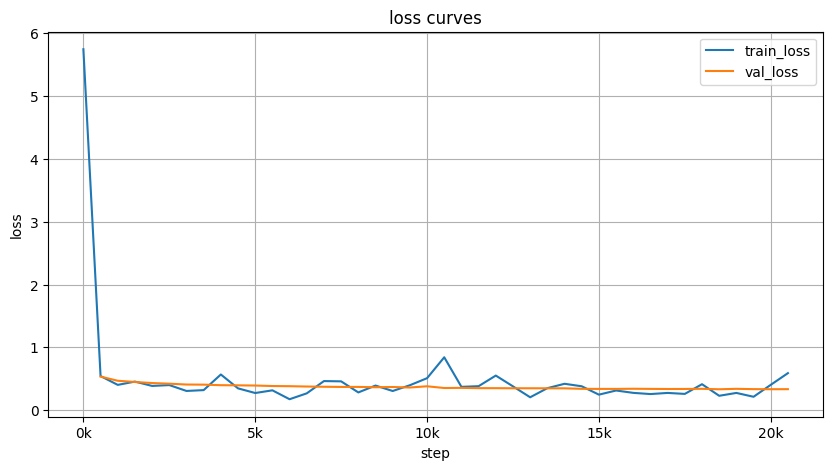

In [9]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3199
